In [12]:
import cirq 
from cirq.contrib.svg import SVGCircuit
from functools import reduce

import numpy as np
from numpy.linalg import matrix_power as mpow

np.set_printoptions(precision=3, suppress=True)

## Utility functions

In [13]:
def kron(*A):
    return reduce(np.kron, A)

def rand_ket(d):
    ket = np.random.randn(d) + 1j*np.random.randn(d)
    return ket/np.linalg.norm(ket)

## Weyl-Heisenberg operators

In [14]:
def wh_operators(d):
    w = np.exp(2*np.pi*1j/d)
    Z = np.diag(np.array([w**i for i in range(d)]))
    F = np.array([[w**(i*j) for j in range(d)] for i in range(d)])/np.sqrt(d)
    X = F.conj().T @ Z @ F
    D = np.array([[mpow(X, i) @ mpow(Z, j)  for j in range(d)] for i in range(d)])
    return locals()

### Check fundamental WH identities

In [15]:
d = 4
globals().update(wh_operators(d))

np.all([np.allclose(D[a], w**(-a[0]*a[1])*mpow(Z, a[1]) @ mpow(X, a[0])) for a in np.ndindex(d,d)]),\
np.all([np.allclose(D[a].conj().T, w**(a[0]*a[1])*D[-a[0] % d, -a[1] % d]) for a in np.ndindex(d,d)]),\
np.all([np.allclose(D[a] @ D[b], w**(a[1]*b[0])*D[(a[0]+b[0])%d, (a[1]+b[1])%d]) for b in np.ndindex(d,d) for a in np.ndindex(d,d)]),\
np.all([np.allclose(D[b] @ D[a] @ D[b].conj().T, w**(a[0]*b[1] - a[1]*b[0])*D[a]) for b in np.ndindex(d,d) for a in np.ndindex(d,d)]),\
np.allclose(np.array([[(D[a].conj().T @ D[b]).trace() for b in np.ndindex(d,d)] for a in np.ndindex(d,d)]), d*np.eye(d**2))

(np.True_, np.True_, np.True_, np.True_, True)

## Basic cirq gates

In [16]:
H = cirq.H
R = lambda k: cirq.ZPowGate(exponent=2**(1-k))
CR = lambda k: cirq.CZPowGate(exponent=2**(1-k))
SWAP = cirq.SWAP

## QFT

In [17]:
def F_(q):
    n = len(q)
    for i in range(n):
        yield H(q[i])
        for j in range(i + 1, n):
            yield CR(j - i + 1)(q[j], q[i])
    for i in range(n // 2):
        yield SWAP(q[i], q[n - 1 - i])

def Fdag_(q):
    yield cirq.inverse(list(F_(q)))

### Check QFT

In [18]:
n = 3    
globals().update(wh_operators(2**n))

q = cirq.LineQubit.range(n)
circuit = cirq.Circuit(F_(q))
print(circuit)

ket = rand_ket(2**n)
s = cirq.Simulator()
final_ket = s.simulate(circuit, initial_state=ket).final_state_vector
np.allclose(final_ket, F @ ket)

                  ┌───────┐
0: ───H───@────────@──────────────────────×───
          │        │                      │
1: ───────@^0.5────┼─────H────@───────────┼───
                   │          │           │
2: ────────────────@^0.25─────@^0.5───H───×───
                  └───────┘


True

## Clock and shift

In [19]:
def Z_(q):
    for i in range(len(q)):
        yield R(i+1)(q[i])

def X_(q):
    yield F_(q)
    yield Z_(q)
    yield Fdag_(q)

### Check clock and shift

In [20]:
n = 3
globals().update(wh_operators(2**n))

q = cirq.LineQubit.range(n)
circuit = cirq.Circuit(X_(q))
print(circuit)

ket = rand_ket(2**n)
s = cirq.Simulator()
final_ket = s.simulate(circuit, initial_state=ket).final_state_vector
np.allclose(final_ket, X @ ket)

                  ┌───────┐                                        ┌────────┐
0: ───H───@────────@──────────────────────×───Z───×──────────────────@──────────@────────H───
          │        │                      │       │                  │          │
1: ───────@^0.5────┼─────H────@───────S───┼───────┼───────@─────────H┼──────────@^-0.5───────
                   │          │           │       │       │          │
2: ────────────────@^0.25─────@^0.5───H───×───T───×───H───@^-0.5─────@^-0.25─────────────────
                  └───────┘                                        └────────┘


True

## Controlled clock and shift

In [21]:
def QCZ_(c, t):
    n = len(t)
    for j in range(n):
        yield CR(j+1)(c, t[j])

def CZ_(c, t):
    n = len(c)
    for j in range(n):
        for k in range(2**j):
            yield QCZ_(c[n-j-1], t)

def CX_(c, t):
    yield F_(t)
    yield CZ_(c, t)
    yield Fdag_(t)

### Viz qubit controlled clock

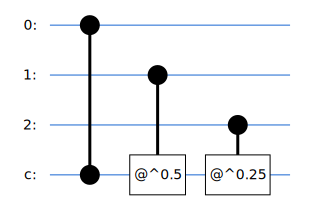

In [22]:
n = 3
globals().update(wh_operators(2**n))
c = cirq.NamedQubit("c")
t = cirq.LineQubit.range(n)
circuit = cirq.Circuit(QCZ_(c, t))
SVGCircuit(circuit)

### Check controlled clock and shift

In [23]:
n = 3
globals().update(wh_operators(2**n))

d = 2**n
Pi_pos = np.array([np.diag(np.eye(d)[i]) for i in range(d)])
U = sum([kron(Pi_pos[k], mpow(Z, k)) for k in range(d)])

t = cirq.LineQubit.range(n)
c = cirq.LineQubit.range(n, 2*n)
circuit = cirq.Circuit()
circuit.append(CZ_(c, t), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
print(circuit)

ket = rand_ket(d**2)
s = cirq.Simulator()
final_ket = s.simulate(circuit, initial_state=ket).final_state_vector
np.allclose(final_ket, U @ ket)

                  ┌───────┐                                ┌───────┐
0: ───@──────────────────@─────────────────────@──────────────────@─────────────────────@────────────────────@────────────────────@────────────────────
      │                  │                     │                  │                     │                    │                    │
1: ───┼───@──────────────┼────@────────────────┼───@──────────────┼────@────────────────┼───@────────────────┼───@────────────────┼───@────────────────
      │   │              │    │                │   │              │    │                │   │                │   │                │   │
2: ───┼───┼────────@─────┼────┼───────@────────┼───┼────────@─────┼────┼───────@────────┼───┼───────@────────┼───┼───────@────────┼───┼───────@────────
      │   │        │     │    │       │        │   │        │     │    │       │        │   │       │        │   │       │        │   │       │
3: ───┼───┼────────┼─────┼────┼───────┼────────┼───┼────────┼──

True

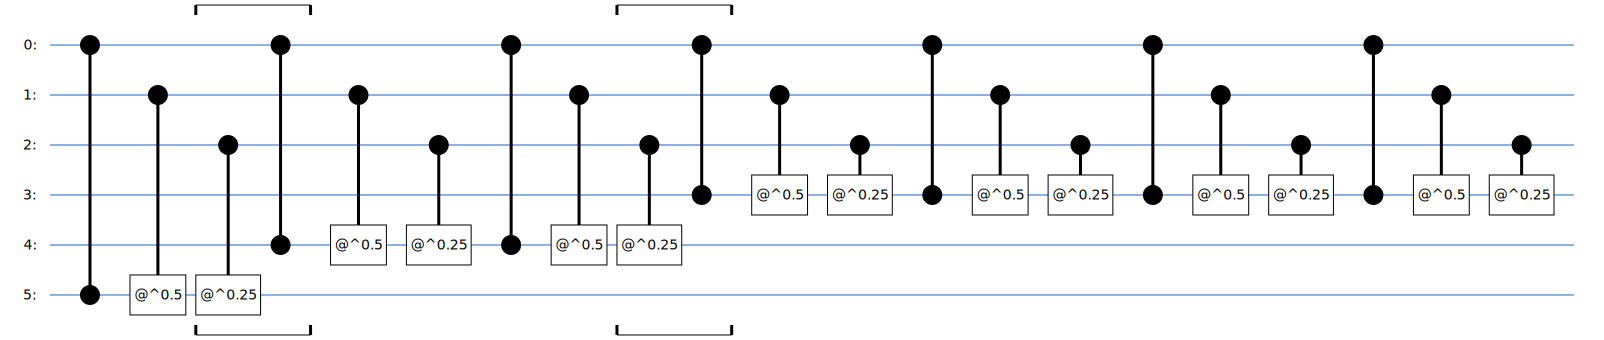

In [24]:
SVGCircuit(circuit)

## d=4 SIC fiducial

In [25]:
n = 2
globals().update(wh_operators(2**n))

w2 = np.sqrt(2)
w5 = np.sqrt(5)
w10 = w2*w5
r1 = np.sqrt(w5 + 1)
psi = np.array([8,\
                ((w10 + w2 - 2*w5 - 2)*r1 - 4)*1j + (w10 + w2)*r1 + 4*w2 - 4,\
                 (8*w2 - 8)*1j,\
                ((w10 + w2 - 2*w5 - 2)*r1 + 4)*1j + (w10 + w2)*r1 - 4*w2 + 4])
psi = psi/np.linalg.norm(psi)
Pi = np.outer(psi, psi.conj())

## Check SIC fiducial

In [26]:
SIC = np.array([D[a] @ Pi @ D[a].conj().T for a in np.ndindex(d,d)])/d
P = np.array([[(a@b/b.trace()).trace() for b in SIC] for a in SIC]).real
P_SIC = np.array([[(d*(1 if i == j else 0) + 1)/(d*(d+1)) for j in range(d**2)] for i in range(d**2)]).real
np.allclose(P, P_SIC)

True

## Qudit Arthurs-Kelly

### Define the unitary

In [27]:
Pi_pos = np.array([np.diag(np.eye(d)[i]) for i in range(d)])
Pi_mom = np.array([np.outer(F[:,i], F[:,i].conj()) for i in range(d)])
U1 = sum([kron(mpow(X, k), np.eye(d), Pi_pos[k]) for k in range(d)])
U2 = sum([kron(np.eye(d), mpow(X, m), Pi_mom[m]) for m in range(d)])
U = U2 @ U1

# Check alternate formulation
U_alt = sum([kron(Pi_mom[k], Pi_mom[m], D[m,-k%d]) for m in range(d) for k in range(d)])
np.allclose(U, U_alt)

True

### Define initial state of ancillas

In [28]:
FPi = F.conj().T @ Pi
gamma = np.array([w**(k*m)*FPi[-m%d,-k%d] for k in range(d) for m in range(d)])

# Check alternate formulation
gamma_alt = d**(-3/2)*np.array([sum([w**(a*m - b*k)*(D[a,b].conj().T @ Pi).trace() for b in range(d) for a in range(d)]) for k in range(d) for m in range(d)])
np.allclose(gamma, gamma_alt)

True

### Check if we recover SIC probabilities

In [29]:
ket = rand_ket(d)
sic_p = np.array([ket.conj() @ e @ ket for e in SIC]).real

initial_state = kron(gamma, ket)
final_state = U @ initial_state
ak_p = np.array([final_state.conj() @ kron(Pi_pos[x], Pi_pos[y], np.eye(d)) @ final_state for x in range(d) for y in range(d)]).real
np.allclose(sic_p, ak_p)

True

### Do it in cirq

In [30]:
t1 = cirq.LineQubit.range(n)
t2 = cirq.LineQubit.range(n, 2*n)
c = cirq.LineQubit.range(2*n, 3*n)
circuit = cirq.Circuit((CX_(c, t1), Fdag_(c), CX_(c, t2), F_(c)), strategy=cirq.InsertStrategy.NEW_THEN_INLINE)
s = cirq.Simulator()
final_state2 = s.simulate(circuit, initial_state=initial_state).final_state_vector
np.allclose(final_state, final_state2)

True

In [31]:
circuit

┌──────┐                                                                                 ┌──────┐
0: ───H───@───────────×───@─────────@────────────@───────────×───────@────────H────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │           │   │         │            │           │       │
1: ───────@^0.5───H───×───┼────@────┼────@───────┼───@───────×───H───@^-0.5────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                          │    │    │    │       │   │
2: ───────────────────────┼────┼────┼────┼───────┼───┼─────────────────────────────────────────H───@───────────×───@─────────@────────────@───────────×───────@────────H───────────────────
                          │    │    │    │       │   │                                             │           │   │         │            │           │       │
3: ───────────────────────┼────┼────┼────┼───────┼───┼─────────────────────────────────────────────@^0.5───H───×───┼────@────┼────@───────┼───@───────×───H───@^-0.5───────────────────────
                          │    │    │    │       │   │                                                             │    │    │    │       │   │
4: ───────────────────────┼────┼────@────@^0.5───@───@^0.5────────────────────×───────@────────H───────────────────┼────┼────@────@^0.5───@───@^0.5────────────────────H───@───────────×───
                          │    │                                              │       │                            │    │                                                  │           │
5: ───────────────────────@────@^0.5──────────────────────────────────────────×───H───@^-0.5───────────────────────@────@^0.5──────────────────────────────────────────────@^0.5───H───×───
                              └──────┘                                                                                 └──────┘

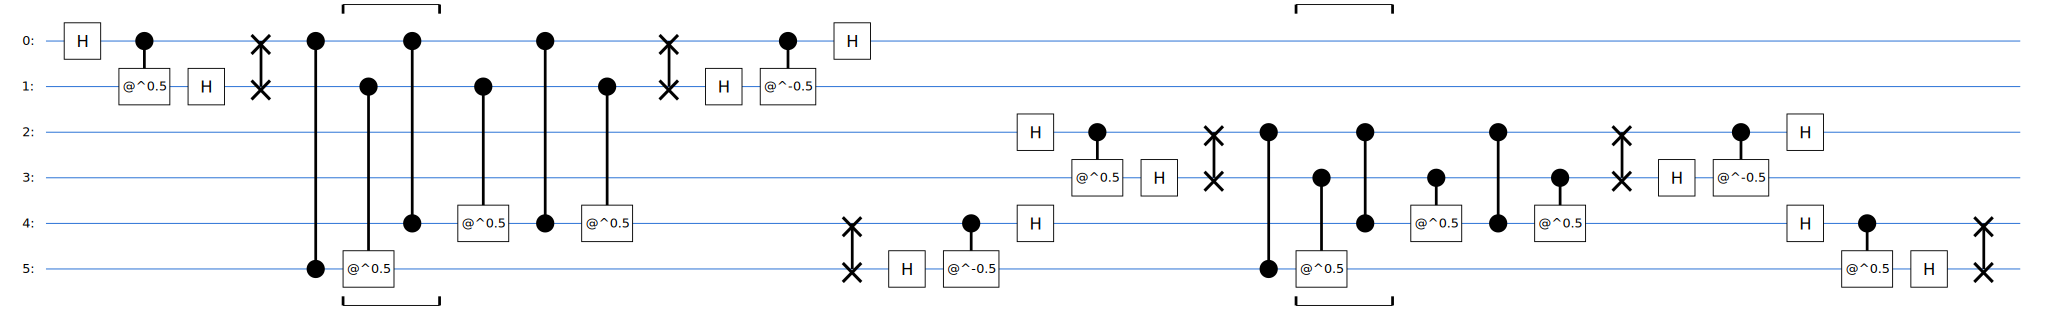

In [32]:
SVGCircuit(circuit)

## Alterative Kraus operators (sans $F$)

In [33]:
U_sans = sum([kron(np.eye(d), mpow(X, k), Pi_pos[k]) for k in range(d)]) @ kron(np.eye(d), np.eye(d), F.conj().T) @ sum([kron(mpow(X, k), np.eye(d), Pi_pos[k]) for k in range(d)])
final_state3 = U_sans @ initial_state
ak_p3 = np.array([final_state.conj() @ kron(Pi_pos[x], Pi_pos[y], np.eye(d)) @ final_state for x in range(d) for y in range(d)]).real
np.allclose(ak_p, ak_p3)

True

In [34]:
# Usual Kraus operators 
K = np.array([kron(np.eye(d)[i], np.eye(d)[j], np.eye(d)) @ U @ kron(gamma, np.eye(d)).T for i in range(d) for j in range(d)])
E2 = np.array([k.conj().T @ k for k in K])
np.allclose(np.array([ket.conj() @ e @ ket for e in E2]).real, ak_p)

True

In [35]:
# Alternate Kraus operators (sans F)
K_sans = np.array([kron(np.eye(d)[i], np.eye(d)[j], np.eye(d)) @ U_sans @ kron(gamma, np.eye(d)).T for i in range(d) for j in range(d)])
E_sans = np.array([k.conj().T @ k for k in K_sans])
np.allclose(np.array([ket.conj() @ e @ ket for e in E_sans]).real, ak_p)

True

In [36]:
np.linalg.eigvals(K[0]), np.linalg.eigvals(K_sans[0])

(array([ 0. +0.j,  0.5-0.j, -0. +0.j, -0. +0.j]),
 array([ 0.354-0.069j,  0.   +0.j   , -0.   +0.j   , -0.   -0.j   ]))

In [37]:
rho = np.outer(ket, ket.conj())

In [38]:
rho0 = (K[0] @ rho @ K[0].conj().T)/(K[0] @ rho @ K[0].conj().T).trace(); rho0

array([[ 0.236-0.j   ,  0.292+0.219j,  0.   -0.098j,  0.194-0.017j],
       [ 0.292-0.219j,  0.563+0.j   , -0.091-0.121j,  0.224-0.201j],
       [ 0.   +0.098j, -0.091+0.121j,  0.04 -0.j   ,  0.007+0.08j ],
       [ 0.194+0.017j,  0.224+0.201j,  0.007-0.08j ,  0.161-0.j   ]])

In [39]:
rho0_sans = (K_sans[0] @ rho @ K_sans[0].conj().T)/(K_sans[0] @ rho @ K_sans[0].conj().T).trace(); rho0_sans

array([[ 0.563+0.j   ,  0.021+0.149j, -0.224-0.201j,  0.361-0.052j],
       [ 0.021-0.149j,  0.04 -0.j   , -0.062+0.052j,  0.   -0.098j],
       [-0.224+0.201j, -0.062-0.052j,  0.161-0.j   , -0.125+0.149j],
       [ 0.361+0.052j,  0.   +0.098j, -0.125-0.149j,  0.236-0.j   ]])

In [40]:
E2[0]/E2[0].trace()

array([[ 0.236-0.j   ,  0.292+0.219j, -0.   -0.098j,  0.194-0.017j],
       [ 0.292-0.219j,  0.563+0.j   , -0.091-0.121j,  0.224-0.201j],
       [-0.   +0.098j, -0.091+0.121j,  0.04 +0.j   ,  0.007+0.08j ],
       [ 0.194+0.017j,  0.224+0.201j,  0.007-0.08j ,  0.161+0.j   ]])

In [41]:
E_sans[0]/E_sans[0].trace()

array([[ 0.236+0.j   ,  0.292+0.219j, -0.   -0.098j,  0.194-0.017j],
       [ 0.292-0.219j,  0.563-0.j   , -0.091-0.121j,  0.224-0.201j],
       [-0.   +0.098j, -0.091+0.121j,  0.04 +0.j   ,  0.007+0.08j ],
       [ 0.194+0.017j,  0.224+0.201j,  0.007-0.08j ,  0.161+0.j   ]])